In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../../core'))
import kaggle_support as kgs
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
import multiprocess as mp
mp.set_start_method("spawn", force=True)
import copy

local


## Configuration

In [2]:
DO_CHECK = False

# User inputs
N_TREES_LIST = [49]
N_PROCESSES = 3 if kgs.env=='local' else 8  # Maximum concurrent processes
DIAGNOSTIC_INTERVAL = 120  # Seconds between diagnostic updates
SEED_BASE = 85  # Base seed for reproducibility

# Set up checkpoint/log directory
CHECKPOINT_DIR = 'controller_runs/' if not DO_CHECK else 'check_runs/'
os.makedirs(kgs.temp_dir + CHECKPOINT_DIR, exist_ok=True)
print(f"Using checkpoint directory: {CHECKPOINT_DIR}")

# Create base runner configuration
import pack_ga3
import pack_runner

base_runner = pack_ga3.baseline()

base_runner.ga.do_legalize = True
base_runner.use_atomic_save = True  # Enable atomic saves for multiprocess safety

base_runner.diagnostic_plot = False  # Disabled in subprocessbase_runner.save_every = 1
if DO_CHECK:
    base_runner.n_generations = 1000

Using checkpoint directory: controller_runs/


## Worker Function

In [3]:
def worker_function(N_trees, seed, base_runner_pickled, checkpoint_dir):
    """
    Worker process that runs GA for a specific N_trees.
    Runs in subprocess - output redirected to log file.
    """
    import sys
    import os
    sys.path.insert(0, os.path.join(os.getcwd(), '../../core'))
    import kaggle_support as kgs
    import copy
    
    # Redirect stdout/stderr to log file
    log_path = kgs.temp_dir + checkpoint_dir + f'ga_N{N_trees}_seed{seed}.log'
    log_file = open(log_path, 'a')
    sys.stdout = log_file
    sys.stderr = log_file
    
    print(f"\n{'='*60}")
    print(f"Starting worker: N_trees={N_trees}, seed={seed}")
    print(f"{'='*60}\n")
    
    try:
        # Unpickle base runner and configure
        import dill
        runner = dill.loads(base_runner_pickled)
        runner.seed = seed
        runner.filename = checkpoint_dir + f'ga_N{N_trees}_seed{seed}'
        
        # Configure for this N_trees
        runner.ga.ga_base.N_trees_to_do = N_trees
        
        # Check for existing checkpoint
        checkpoint_path =  kgs.temp_dir + runner.filename + '.pickle'
        if os.path.isfile(checkpoint_path):
            print(f"Loading checkpoint: {checkpoint_path}")
            runner = kgs.dill_load(checkpoint_path)
        
        # Run with atomic saves (enabled via use_atomic_save flag)
        runner.run()
        
        print(f"\nCompleted: N_trees={N_trees}, final generation={runner._current_generation}")
        
    except Exception as e:
        import traceback
        print(f"\nERROR in worker N_trees={N_trees}:")
        traceback.print_exc()
    finally:
        log_file.close()

## Process Manager

In [4]:
class ProcessManager:
    """Manages pool of worker processes."""
    
    def __init__(self, N_trees_list, n_processes, base_runner, checkpoint_dir):
        self.N_trees_list = list(N_trees_list)
        self.n_processes = n_processes
        self.checkpoint_dir = checkpoint_dir
        self.base_runner_pickled = kgs.dill.dumps(base_runner)
        
        self.pending_tasks = [(N, SEED_BASE) for N in N_trees_list]
        self.running = {}  # {Process: (N_trees, seed)}
        self.completed = set()  # Set of N_trees values
        self.errored = {}  # {N_trees: exit_code}
        self.last_start_time = 0  # Track last process start time
        
    def start_process(self, N_trees, seed):
        """Start a new worker process."""
        p = mp.Process(target=worker_function, 
                      args=(N_trees, seed, self.base_runner_pickled, self.checkpoint_dir))
        p.start()
        self.running[p] = (N_trees, seed)
        self.last_start_time = time.time()
        print(f"Started process for N_trees={N_trees} (PID: {p.pid})")
        
    def update(self):
        """Check for completed processes and start new ones."""
        # Check running processes
        for p in list(self.running.keys()):
            if not p.is_alive():
                N_trees, seed = self.running[p]
                p.join()
                del self.running[p]
                if p.exitcode == 0:
                    self.completed.add(N_trees)
                    print(f"Process completed: N_trees={N_trees}")
                else:
                    self.errored[N_trees] = p.exitcode
                    print(f"Process FAILED: N_trees={N_trees} (exit code: {p.exitcode})")
        
        # Start new processes if slots available
        while len(self.running) < self.n_processes and self.pending_tasks:
            # Stagger startup: wait 5 seconds after last start
            time_since_last_start = time.time() - self.last_start_time
            if time_since_last_start < 5.0:
                time.sleep(5.0 - time_since_last_start)
            
            N_trees, seed = self.pending_tasks.pop(0)
            self.start_process(N_trees, seed)
    
    def get_status(self, N_trees):
        """Get status of a specific N_trees value."""
        if N_trees in self.errored:
            return f"ERROR (exit {self.errored[N_trees]})"
        if N_trees in self.completed:
            return "DONE"
        for p, (nt, seed) in self.running.items():
            if nt == N_trees:
                return "RUNNING"
        for nt, seed in self.pending_tasks:
            if nt == N_trees:
                return "PENDING"
        return "UNKNOWN"
    
    def is_complete(self):
        """Check if all tasks are done."""
        return len(self.pending_tasks) == 0 and len(self.running) == 0
    
    def status(self):
        """Return status string."""
        return (f"Running: {len(self.running)}, "
                f"Pending: {len(self.pending_tasks)}, "
                f"Completed: {len(self.completed)}, "
                f"Errored: {len(self.errored)}")

## Diagnostic Display

In [5]:
def display_diagnostics(N_trees_list, checkpoint_dir, manager):
    """
    Load all runner pickles and display diagnostic plots.
    Handles missing/corrupted files gracefully.
    """
    
    # First, load all pickle files before clearing display
    runners = {}
    status_info = {}  # Store status and error messages
    
    for N_trees in N_trees_list:
        status = manager.get_status(N_trees)
        filename = f'ga_N{N_trees}_seed{SEED_BASE}'
        pickle_path = kgs.temp_dir + checkpoint_dir + filename + '.pickle'
        
        if os.path.isfile(pickle_path):
            try:
                runner = kgs.dill_load(pickle_path)
                runners[N_trees] = runner
                
                # Store info for later display
                best_costs = [[round(float(x), 6) for x in s[-1].flatten()] 
                              for s in runner.ga.best_costs_per_generation]
                status_info[N_trees] = {
                    'status': status,
                    'type': 'loaded',
                    'message': f"N={N_trees} [{status:8s}]: Gen {runner._current_generation}/{runner.n_generations} | Best: {best_costs}"
                }
            except Exception as e:
                status_info[N_trees] = {
                    'status': status,
                    'type': 'error',
                    'message': f"N={N_trees} [{status:8s}]: Error loading pickle - {str(e)[:50]}"
                }
        else:
            status_info[N_trees] = {
                'status': status,
                'type': 'missing',
                'message': f"N={N_trees} [{status:8s}]: No checkpoint found"
            }
    
    # Now clear output and display everything
    clear_output(wait=True)
    
    print(f"{'='*60}")
    print(f"Diagnostics Update - {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"{'='*60}\n")
    
    # Print all status messages
    for N_trees in N_trees_list:
        print(status_info[N_trees]['message'])
    
    print(f"\n{'='*60}\n")
    
    # Display diagnostic plots for each runner
    for N_trees, runner in runners.items():
        try:
            runner.ga.diagnostic_plots(runner._current_generation - 1, None)            
            #plt.suptitle(f"N_trees={N_trees} (Gen {runner._current_generation})")
            #plt.show()
        except Exception as e:
            print(f"Error displaying diagnostics for N={N_trees}: {e}")

    plt.close('all')  # Close figures to prevent accumulation

## Main Controller Loop

Diagnostics Update - 2025-12-30 13:06:51

N=49 [RUNNING ]: Gen 1580/60000 | Best: [[0.353247, 2.4e-05]]




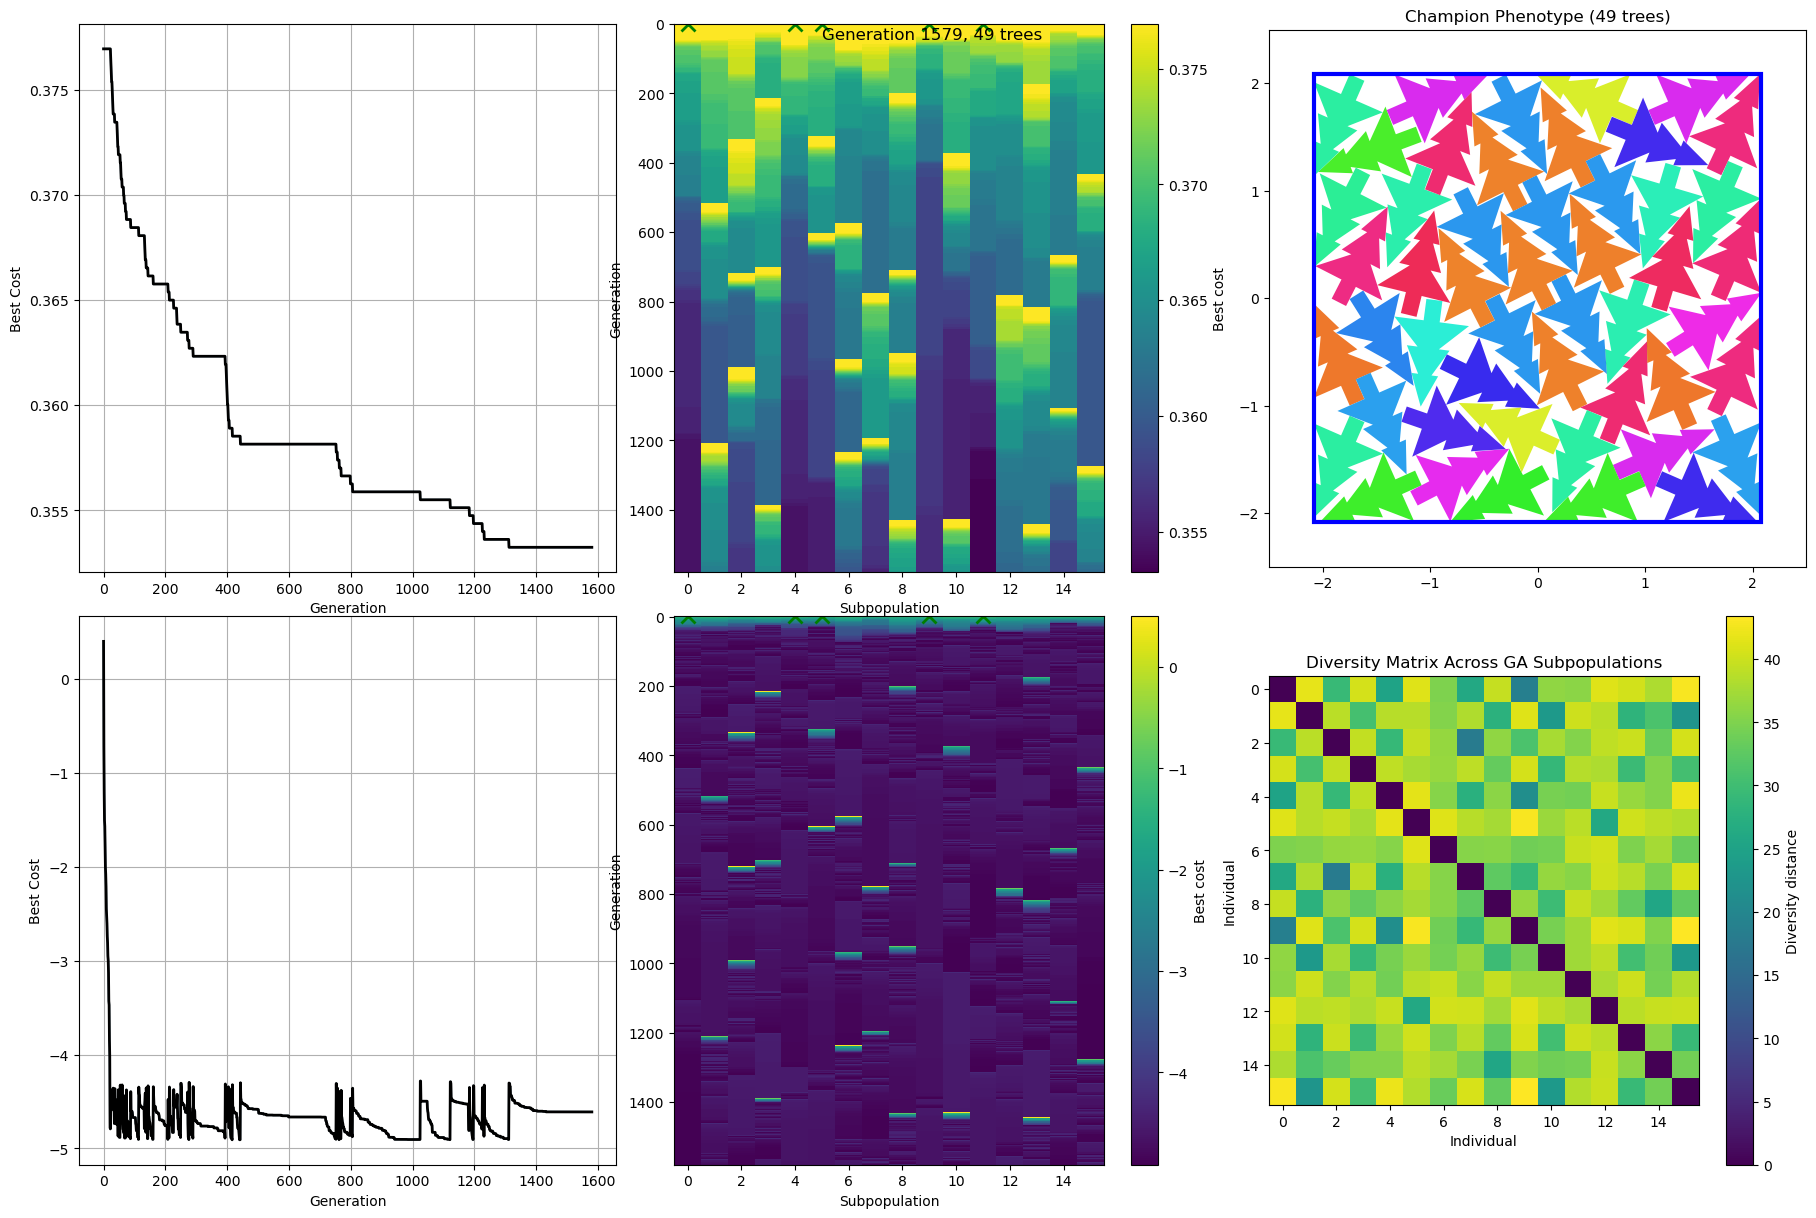


Status: Running: 1, Pending: 0, Completed: 0, Errored: 0



In [ ]:
# Initialize process manager
manager = ProcessManager(N_TREES_LIST, N_PROCESSES, base_runner, CHECKPOINT_DIR)

print(f"Starting controller for N_trees={N_TREES_LIST}")
print(f"Max concurrent processes: {N_PROCESSES}")
print(f"Diagnostic interval: {DIAGNOSTIC_INTERVAL}s\n")

last_diagnostic_time = 0

try:
    while not manager.is_complete():
        # Update process pool
        manager.update()
        
        # Display diagnostics periodically
        current_time = time.time()
        if current_time - last_diagnostic_time >= DIAGNOSTIC_INTERVAL:
            display_diagnostics(N_TREES_LIST, CHECKPOINT_DIR, manager)
            print(f"\nStatus: {manager.status()}\n")
            last_diagnostic_time = current_time
        
        # Sleep briefly to avoid busy-waiting
        time.sleep(1)
    
    # Final update
    print("\n" + "="*60)
    print("All processes completed!")
    print("="*60 + "\n")
    display_diagnostics(N_TREES_LIST, CHECKPOINT_DIR, manager)
    
except KeyboardInterrupt:
    print("\n\nInterrupted by user!")
    print("Terminating running processes...")
    for p in manager.running.keys():
        p.terminate()
        p.join()
    print("Cleanup complete.")

## Post-Processing

In [ ]:
# Load all completed runners for analysis
completed_runners = {}

for N_trees in N_TREES_LIST:
    filename = f'ga_N{N_trees}_seed{SEED_BASE}'
    pickle_path = kgs.temp_dir + CHECKPOINT_DIR + filename + '.pickle'
    
    if os.path.isfile(pickle_path):
        try:
            runner = kgs.dill_load(pickle_path)
            completed_runners[N_trees] = runner
            print(f"Loaded N={N_trees}: {runner._current_generation} generations")
        except Exception as e:
            print(f"Failed to load N={N_trees}: {e}")

print(f"\nTotal loaded: {len(completed_runners)} runners")

In [ ]:
# Extract best solutions
import pack_vis_sol

for N_trees, runner in completed_runners.items():
    best_costs = [[float(x) for x in s[-1].flatten()] 
                  for s in runner.ga.best_costs_per_generation]
    print(f"\nN={N_trees}: Best costs = {best_costs}")
    
    # Visualize best solution
    # (Adjust based on your GA structure - GAMulti vs single GA)
    try:
        plt.figure()
        pack_vis_sol.pack_vis_sol(runner.ga.champions[-1].phenotype)
        plt.title(f"N={N_trees}, Cost={runner.ga.champions[-1].fitness[0]}")
    except Exception as e:
        print(f"Could not visualize N={N_trees}: {e}")